In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from sklearn.svm import SVR
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

## a. We want to make a regression model to predict the wear of the drive shaft. First, split the dataset in a train and test. Use the train set to plot the data in a suitable manner. 

In [7]:
# Split the dataset in a train and test.
shaft_data = pd.read_csv('shaft_radius.csv')
X = shaft_data['measurement_index'].values.reshape(-1,1)
y = shaft_data['shaft_radius']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state = 2)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


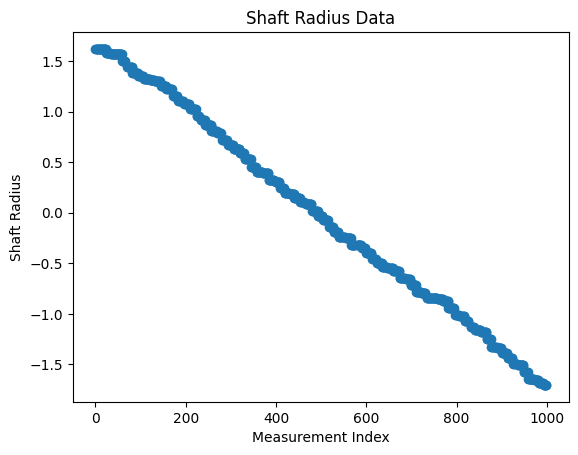

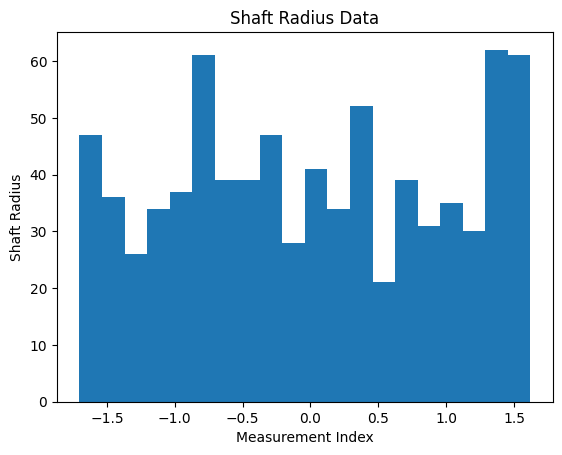

In [26]:
# Use the train set to plot the data. 
plt.scatter(X_train, y_train)
plt.xlabel('Measurement Index')
plt.ylabel('Shaft Radius')
plt.title('Shaft Radius Data')
plt.show()

plt.hist(y_train, bins=20)
plt.xlabel('Shaft Radius')
plt.ylabel('Frequency')
plt.title('Shaft Radius Data')
plt.show()

# The plot seems pretty linear.

## b. Make a regression model to predict radius of the drive shaft based on the time that the drive shaft had been running. Explain why you chose this regression model.

In [9]:
def evaluate_model(model, X, y):
    """
    Evaluate the performance of a model on a given dataset.

    Parameters:
    - model: a scikit-learn model object
    - X: feature matrix
    - y: target vector

    Returns:
    - a dictionary with evaluation metrics (MSE, R2, cross-validation score)
    """
    # Split the data into training and testing sets (80% for training, 20% for testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=2)

    # Scale the data using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Predict on the test data
    y_test_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    print("\nModel Evaluation Results:")
    print(f"MSE: {mse:.4f}")
    print(f"R2 Score: {r2:.4f}")

    # Calculate cross-validation score using R-squared as the scoring metric
    scores = cross_val_score(model, X_test, y_test, scoring='r2', cv=10)
    print(f"Cross-Validation Score (R-squared): {np.mean(scores):.4f}")

    # Plot the true and predicted shaft radius values
    plt.scatter(X_test, y_test, color='blue', label='True Test Data')
    plt.scatter(X_test, y_test_pred, color='red', label='Predicted Test Data')
    plt.xlabel('Measurement Index')
    plt.ylabel('Shaft Radius')
    plt.title('True vs Predicted Shaft Radius ')
    plt.legend()
    plt.show()

    # Calculate residuals (y - y_pred)
    residuals = y_test - y_test_pred

    # Plot the distribution of residuals using a histogram and kernel density estimate (KDE)
    plt.figure()
    plt.hist(residuals, bins=20, alpha=0.5, label='Histogram')
    sns.kdeplot(residuals, ax=plt.gca(), label='KDE')
    plt.title('Distribution of model residuals')
    plt.xlabel('Residuals ($y-\hat y$)')
    plt.ylabel('Frequency')
    plt.grid()
    plt.legend()
    plt.show()

    # Return a dictionary with evaluation metrics
    return {
        'se': mse,
        'r2': r2,
        'cv_score': np.mean(scores)
    }

## Linear Regression

Intercept:  [-5.86187271e-16]
Slope:  [-0.99921295]
Linear Regression's Equation: [-0.99921295]x + [-5.86187271e-16]

Model Evaluation Results:
MSE: 0.0000
R2 Score: 0.9969
Cross-Validation Score (R-squared): 0.9965


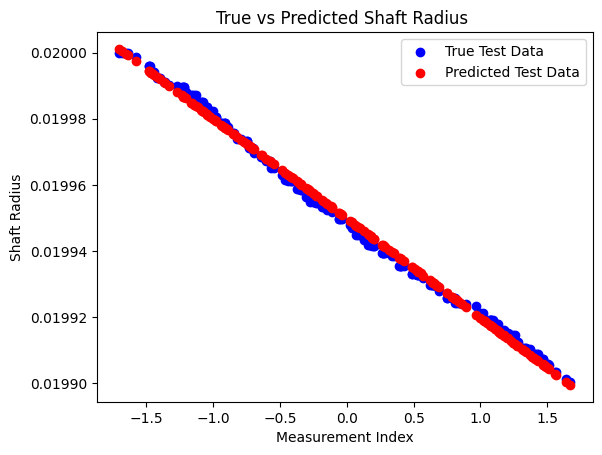

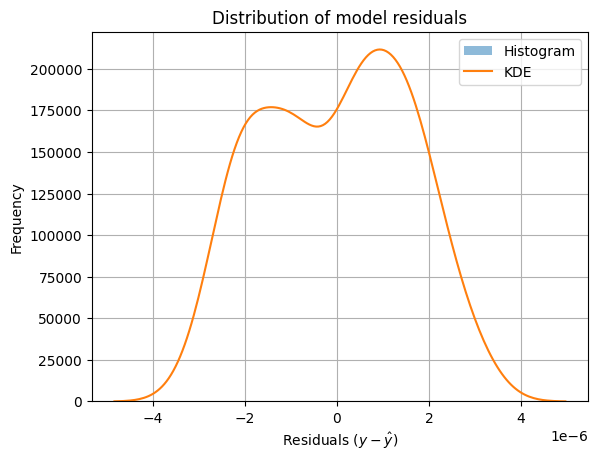

{'mse': 2.52383511801482e-12,
 'r2': 0.9969338564268881,
 'cv_score': 0.996490807055822}

In [23]:
# Because of the linear pattern and continuous (quantitative) variables seen in the data,
# we used linear regression.
linreg_model = LinearRegression()

# Fit the linear regression model to the scaled training data
linreg_model.fit(X_train_scaled, y_train)

# Print the intercept and slope of the linear regression equation
print("Intercept: ", linreg_model.intercept_)
print("Slope: ", linreg_model.coef_[0])

# Print the linear regression equation in the format y = mx + b
print(f'Linear Regression\'s Equation: {np.round(linreg_model.coef_[0], 8)}x + {linreg_model.intercept_}')

# Evaluate the  model
evaluate_model(linreg_model, X, y)

# Note: However, the residuals are not normally distributed, which suggests that the data might include non-linear patterns.
# This could indicate that a linear model is not sufficient to capture the underlying relationships in the data.

## Polynomial Regression

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=5)),
                ('linearregression', LinearRegression())])

Model Evaluation Results:
MSE: 0.0000
R2 Score: 0.9994
Cross-Validation Score (R-squared): 0.9994


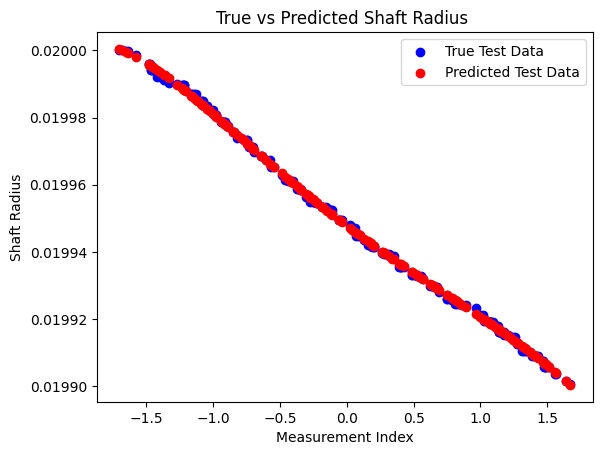

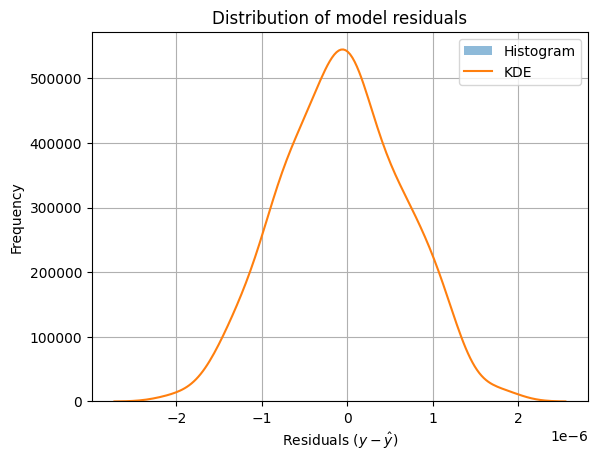

{'mse': 4.9618779135415e-13,
 'r2': 0.9993971939780624,
 'cv_score': 0.9993505475840058}

In [22]:
# Create a pipeline that combines PolynomialFeatures with LinearRegression
poly_model = make_pipeline(PolynomialFeatures(), LinearRegression())

# Define a grid of hyperparameters to search for the polynomial degree
param_grid = {'polynomialfeatures__degree': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

# Create a GridSearchCV object to perform hyperparameter tuning
grid_search = GridSearchCV(
    estimator=poly_model,  # the pipeline to tune
    param_grid=param_grid,  # the grid of hyperparameters to search
    cv=5,  # number of folds for cross-validation
    scoring='neg_mean_squared_error'  # the metric to optimize (lower is better)
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best-performing model (i.e., the one with the lowest mean squared error)
print(grid_search.best_estimator_)

# Extract the best polynomial degree from the grid search results
best_degree = grid_search.best_params_['polynomialfeatures__degree']

# Create a new pipeline with the best polynomial degree
poly_model_best = make_pipeline(
    PolynomialFeatures(degree=best_degree),  # use the best polynomial degree
    LinearRegression()
)

# Evaluate the  best model
evaluate_model(poly_model_best, X, y)

## Lasso & Ridge (Regularization)


Model Evaluation Results:
MSE: 0.0000
R2 Score: 0.9987
Cross-Validation Score (R-squared): 0.9990


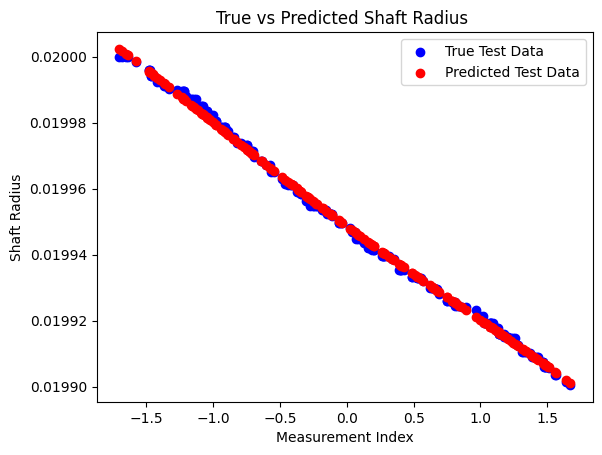

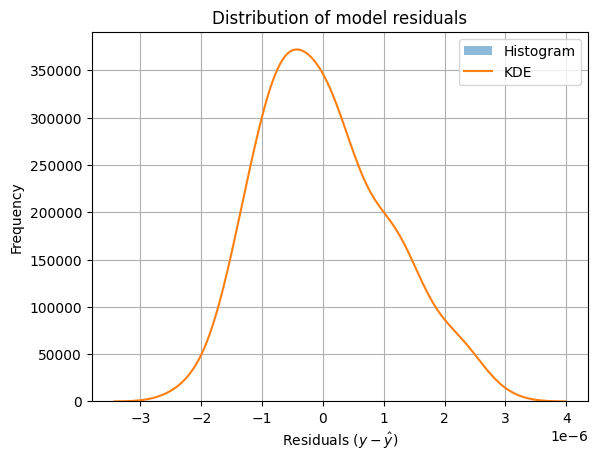


Model Evaluation Results:
MSE: 0.0000
R2 Score: 0.9994
Cross-Validation Score (R-squared): 0.9993


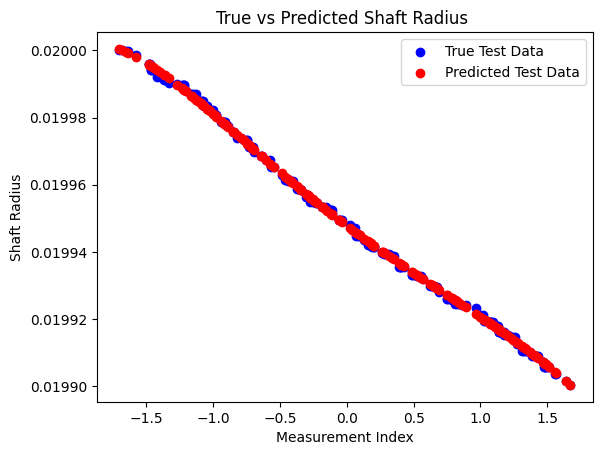

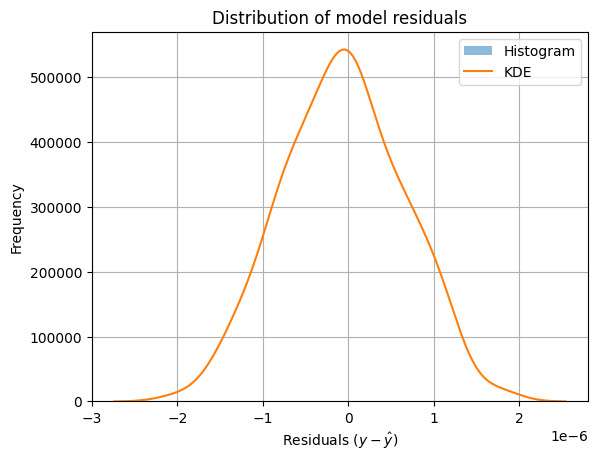

{'mse': 4.986167594339951e-13,
 'r2': 0.9993942430860591,
 'cv_score': 0.9993435793103762}

In [21]:
# Fit the best polynomial regression model from GridSearchCV
poly_model_best = poly_model_best.steps[0][1]

# Define the Lasso regression model with cross-validation
lasso_model = make_pipeline(poly_model_best, LassoCV(cv=100))

# Define the Ridge regression model with cross-validation
ridge_model = make_pipeline(poly_model_best, RidgeCV(cv=100))

# Evaluate the model
evaluate_model(lasso_model, X, y)
evaluate_model(ridge_model, X, y)

## SVR


Model Evaluation Results:
MSE: 0.0000
R2 Score: -0.0026
Cross-Validation Score (R-squared): -0.0967


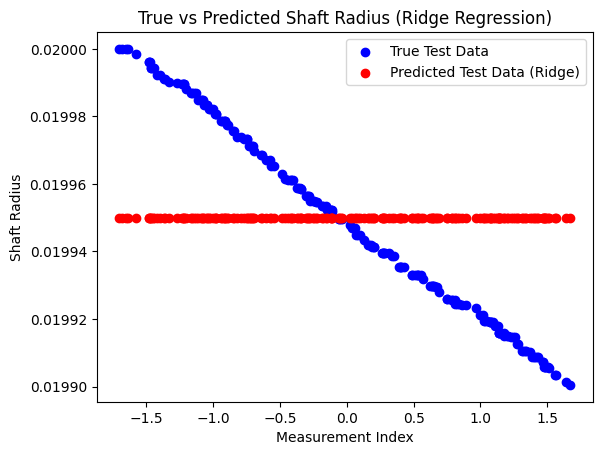

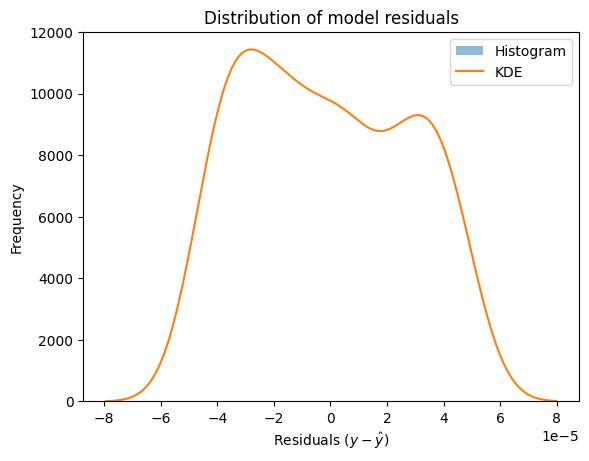

{'mse': 8.252807680662381e-10,
 'r2': -0.002612771712864781,
 'cv_score': -0.09667476668460487}

In [ ]:
# Define a grid of hyperparameters to search for the SVR model
param_grid = {
    'C': [0.1, 1, 10],  # regularization strength
    'kernel': ['linear', 'rbf', 'poly'],  # kernel type
    'degree': [2, 3, 4],  # degree of the polynomial kernel
    'epsilon': [0.1, 0.5, 1]  # epsilon value for the epsilon-insensitive loss function
}

# Create an instance of the Support Vector Regression (SVR) model
svr = SVR()

# Create a GridSearchCV object to perform hyperparameter tuning
grid_search = GridSearchCV(
    estimator=svr,  # the estimator to tune (SVR)
    param_grid=param_grid,  # the grid of hyperparameters to search
    cv=5,  # number of folds for cross-validation
    scoring='neg_mean_absolute_error'  # the metric to optimize (lower is better)
)

# Fit the grid search to the training data
grid_search.fit(X_train.reshape(-1, 1), y_train)

# Extract the best-performing model (i.e., the one with the lowest mean absolute error)
bgr = grid_search.best_estimator_

# Evaluate the  best model
evaluate_model(bgr, X, y)

## RandomForestRegressor

In [ ]:
# Create a RandomForestRegressor object with a fixed random state
rf = RandomForestRegressor(random_state=42)

# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # number of trees in the forest
    'max_depth': [None, 2, 4, 6, 8, 10],  # maximum depth of each tree
    'min_samples_split': [2, 10, 20, 40]  # minimum samples required to split an internal node
}

# Create a GridSearchCV object to perform hyperparameter tuning
gcv_rf = GridSearchCV(
    estimator=rf,  # the estimator to tune (RandomForestRegressor)
    param_grid=param_grid,  # the grid of hyperparameters to search
    cv=3,  # number of folds for cross-validation
    n_jobs=-1,  # use all available CPU cores for parallel processing
    verbose=3,  # print detailed output during the search process
    scoring='neg_mean_absolute_error'  # the metric to optimize (lower is better)
)

# Perform the hyperparameter search and fit the best model to the training data
gcv_rf.fit(X_train, y_train)

# Extract the best hyperparameters and the corresponding model
best_rf = gcv_rf.best_estimator_
best_params = gcv_rf.best_params_
best_score = gcv_rf.best_score_

# Print the results
print('Best hyperparameter(s):', best_params)
print('Best score:', best_score)
print('Best model:', best_rf)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best hyperparameter(s): {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best score: -1.9193036289971772e-07
Best model: RandomForestRegressor(n_estimators=200, random_state=42)



Model Evaluation Results:
MSE: 0.0000
R2 Score: 0.9999
Cross-Validation Score (R-squared): 0.9996


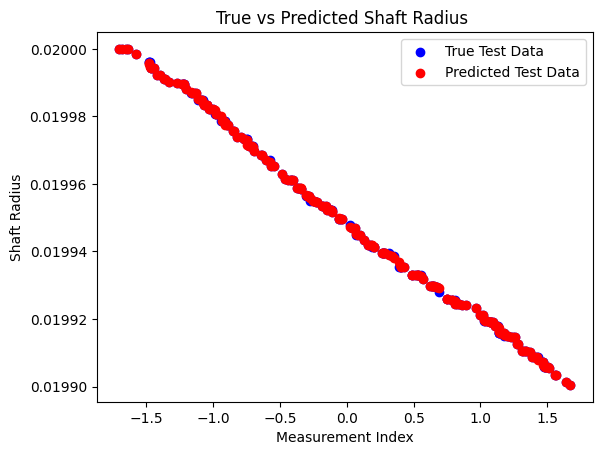

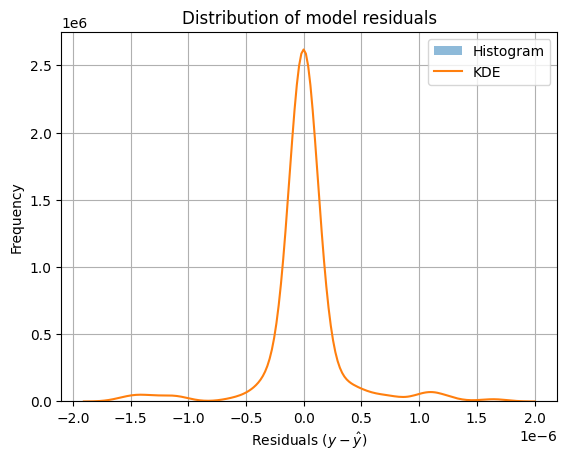

{'mse': 1.185509747275997e-13,
 'r2': 0.9998559754135076,
 'cv_score': 0.9995742655471123}

In [ ]:
# Evaluate the best model
evaluate_model(best_rf, X, y)